Analysis of differential ribosome-protected fragment enrichment between eS27-FLAG and eS27L-FLAG total and IP ribosome fractions

Notes:

1. perform filterByExpr on cpm values, not raw counts
2. perform TMM normalization separately on ip and tot samples since the mito and other universally IP-depleted genes may skew the normalization if all performed together
3. only using CDS counts

In [1]:
library(limma)
library(edgeR)
library(ggplot2)

project_dir = "/labs/mbarna/users/adelexu/s27l-flag-riboprof/"

In [2]:
# this file, with gene counts within the CDS for each transcript (rows) in each sample (columns), 
# is collated from the *_readcounts.txt files generated during the processing steps
source_path = '/labs/mbarna/users/adelexu/s27l-flag-riboprof/reads_cds_v_samp.txt'
counts = read.table(source_path, sep='\t', header=TRUE, row.names=1)

# rename columns for easier parsing of sample info
colnames(counts) = c('L1_2b12_ip_rfp', 'L1_2b12_tot_rfp', 'L1_4a2_ip_rfp', 'L1_4a2_tot_rfp', 'L1_5a1_tot_rfp',
                    'L2_2c3_ip_rfp', 'L2_2c3_tot_rfp', 'L2_4a3_ip_rfp', 'L2_4a3_tot_rfp', 'L2_5a2_tot_rfp',
                    'L3_2c4_ip_rfp', 'L3_2c4_tot_rfp', 'L3_4b7_ip_rfp', 'L3_4b7_tot_rfp', 'L3_5a3_tot_rfp')

dim(counts)

[1] 21727    15

In [3]:
# convert to gene names
mart_path = '/labs/mbarna/users/adelexu/s27l-flag-riboprof/biomart/mart_jan2020_gene_transcript_name.txt'
mart = read.table(mart_path, sep='\t', header=TRUE)
rownames(mart) = mart$Transcript.stable.ID

name_for_tid = mart[,"Gene.name"]
names(name_for_tid) = rownames(mart)
rownames(counts) = paste(name_for_tid[rownames(counts)], rownames(counts), sep='_')
head(counts)

,L1_2b12_ip_rfp,L1_2b12_tot_rfp,L1_4a2_ip_rfp,L1_4a2_tot_rfp,L1_5a1_tot_rfp,L2_2c3_ip_rfp,L2_2c3_tot_rfp,L2_4a3_ip_rfp,L2_4a3_tot_rfp,L2_5a2_tot_rfp,L3_2c4_ip_rfp,L3_2c4_tot_rfp,L3_4b7_ip_rfp,L3_4b7_tot_rfp,L3_5a3_tot_rfp
Gnai3_ENSMUST00000000001,1102,1232,837,1237,1182,810,1153,661,1331,1038,612,907,559,951,985
Hoxb9_ENSMUST00000000010,3,2,2,3,1,2,1,3,2,1,1,0,0,2,0
Cdc45_ENSMUST00000000028,699,922,605,920,803,538,738,509,1051,816,454,739,467,857,679
Apoh_ENSMUST00000000049,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Cav2_ENSMUST00000000058,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Klf6_ENSMUST00000000080,374,347,283,371,311,207,243,229,446,241,162,204,127,200,209


In [4]:
# exclude mitochondrial genes
counts = counts[-grep('^mt-*', rownames(counts)),]
dim(counts)

[1] 21714    15

In [5]:
# parse and assemble sample data
samples = array(data=NA, dim=c(ncol(counts), 3))
rownames(samples) = colnames(counts)
colnames(samples) = c('lane', 'clone', 'treatment')

splits = strsplit(colnames(counts), '_')
for (i in 1:nrow(samples)) {
    samples[i,] = splits[[i]][1:3]
}

samples = data.frame(samples)
samples$treatment = factor(samples$treatment, levels=c('tot', 'ip'))
samples$line = factor(substr(samples$clone, 1, 1), levels = c(2, 4, 5))
samples$line_label = factor(samples$line, labels = c('S27_FLAG', 'S27L_FLAG', 'Unedited'))
samples$line_treatment = paste(samples$line, samples$treatment, sep='')
samples

,lane,clone,treatment,line,line_label,line_treatment
L1_2b12_ip_rfp,L1,2b12,ip,2,S27_FLAG,2ip
L1_2b12_tot_rfp,L1,2b12,tot,2,S27_FLAG,2tot
L1_4a2_ip_rfp,L1,4a2,ip,4,S27L_FLAG,4ip
L1_4a2_tot_rfp,L1,4a2,tot,4,S27L_FLAG,4tot
L1_5a1_tot_rfp,L1,5a1,tot,5,Unedited,5tot
L2_2c3_ip_rfp,L2,2c3,ip,2,S27_FLAG,2ip
L2_2c3_tot_rfp,L2,2c3,tot,2,S27_FLAG,2tot
L2_4a3_ip_rfp,L2,4a3,ip,4,S27L_FLAG,4ip
L2_4a3_tot_rfp,L2,4a3,tot,4,S27L_FLAG,4tot
L2_5a2_tot_rfp,L2,5a2,tot,5,Unedited,5tot


In [6]:
data = DGEList(counts = counts, samples = samples, group = samples$line_treatment)

line_label = data$samples$line_label
treatment = data$samples$treatment
bio_rep = data$samples$lane
clone = data$samples$clone

design = model.matrix(~0+line_label+line_label:bio_rep+line_label:treatment)
colnames(design) = gsub(':', '_', colnames(design))

data_cpm = cpm(data, log=FALSE)
head(data_cpm)

,L1_2b12_ip_rfp,L1_2b12_tot_rfp,L1_4a2_ip_rfp,L1_4a2_tot_rfp,L1_5a1_tot_rfp,L2_2c3_ip_rfp,L2_2c3_tot_rfp,L2_4a3_ip_rfp,L2_4a3_tot_rfp,L2_5a2_tot_rfp,L3_2c4_ip_rfp,L3_2c4_tot_rfp,L3_4b7_ip_rfp,L3_4b7_tot_rfp,L3_5a3_tot_rfp
Gnai3_ENSMUST00000000001,165.1880438,159.8315749,149.9491570,163.7215104,166.6876789,143.4038987,160.562171,147.0579729,166.1069449,136.2770578,136.7433368,144.5698251,140.80143,149.7790405,143.04722
Hoxb9_ENSMUST00000000010,0.4496952,0.2594668,0.3583015,0.3970611,0.1410217,0.3540837,0.139256,0.6674341,0.2495972,0.1312881,0.2234368,0.0000000,0.00000,0.3149927,0.00000
Cdc45_ENSMUST00000000028,104.7789860,119.6142143,108.3861888,121.7653917,113.2404451,95.2485154,102.770930,113.2413135,131.1633352,107.1310975,101.4403185,117.7917318,117.62839,134.9743824,98.60819
Apoh_ENSMUST00000000049,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.1247986,0.0000000,0.0000000,0.0000000,0.00000,0.0000000,0.00000
Cav2_ENSMUST00000000058,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.1593934,0.00000,0.0000000,0.00000
Klf6_ENSMUST00000000080,56.0620040,45.0174971,50.6996552,49.1032177,43.8577565,36.6476630,33.839209,50.9474672,55.6601784,31.6404344,36.1967656,32.5162561,31.98888,31.4992724,30.35215


In [7]:
keep = filterByExpr(data_cpm, min.count=2)
table(keep)

keep
FALSE  TRUE 
11629 10085 

In [8]:
sum(rowSums(data_cpm > 2)>=14) # the above is equivalent to requiring that transcripts be >2 CPM in at least 14/15 samples

[1] 10085

Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

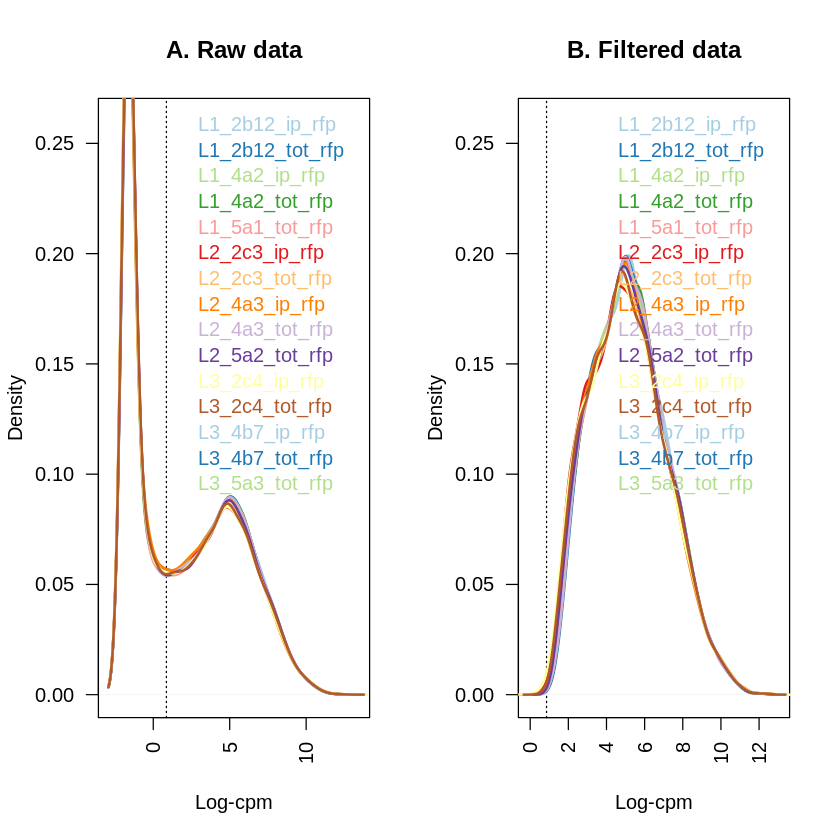

In [9]:
L <- mean(data$samples$lib.size) * 1e-6
M <- median(data$samples$lib.size) * 1e-6

lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(data)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))

lcpm <- cpm(data, log=TRUE)

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data$samples), text.col=col, bty="n")

data = data[keep, keep.lib.sizes=FALSE]

lcpm <- cpm(data, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
den <- density(lcpm[,i])
lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data$samples), text.col=col, bty="n")

In [10]:
data_ip = data[,samples$treatment=='ip']
data_tot= data[,samples$treatment=='tot']

data_ip
data_tot

,L1_2b12_ip_rfp,L1_4a2_ip_rfp,L2_2c3_ip_rfp,L2_4a3_ip_rfp,L3_2c4_ip_rfp,L3_4b7_ip_rfp
Gnai3_ENSMUST00000000001,1102,837,810,661,612,559
Cdc45_ENSMUST00000000028,699,605,538,509,454,467
Klf6_ENSMUST00000000080,374,283,207,229,162,127
Scmh1_ENSMUST00000000087,68,41,46,24,20,34
Cox5a_ENSMUST00000000090,2585,2244,2401,1835,1996,1874
Ngfr_ENSMUST00000000122,156,107,103,66,81,60
Fer_ENSMUST00000000129,257,206,273,185,236,198
Actr2_ENSMUST00000000137,3196,2793,2604,2174,2078,1908
Gna12_ENSMUST00000000153,81,64,61,57,54,39
Sdhd_ENSMUST00000000175,775,638,617,483,471,415


,L1_2b12_tot_rfp,L1_4a2_tot_rfp,L1_5a1_tot_rfp,L2_2c3_tot_rfp,L2_4a3_tot_rfp,L2_5a2_tot_rfp,L3_2c4_tot_rfp,L3_4b7_tot_rfp,L3_5a3_tot_rfp
Gnai3_ENSMUST00000000001,1232,1237,1182,1153,1331,1038,907,951,985
Cdc45_ENSMUST00000000028,922,920,803,738,1051,816,739,857,679
Klf6_ENSMUST00000000080,347,371,311,243,446,241,204,200,209
Scmh1_ENSMUST00000000087,64,79,66,39,74,51,34,54,60
Cox5a_ENSMUST00000000090,2655,2605,2431,2512,2764,2681,2408,2468,2431
Ngfr_ENSMUST00000000122,177,133,113,111,138,132,75,98,145
Fer_ENSMUST00000000129,322,291,292,346,364,452,337,350,326
Actr2_ENSMUST00000000137,3682,3714,3419,3313,3816,3411,2864,3021,3175
Gna12_ENSMUST00000000153,85,96,113,96,91,98,83,105,104
Sdhd_ENSMUST00000000175,825,833,778,661,876,723,574,629,682


In [11]:
data_ip = calcNormFactors(data_ip, method='TMM')
data_ip$samples$norm.factors

data_tot = calcNormFactors(data_tot, method='TMM')
data_tot$samples$norm.factors

[1] 1.0438912 1.0178451 0.9811225 0.9943063 0.9745664 0.9899383

[1] 1.0214500 1.0224780 1.0128338 0.9844647 1.0172453 0.9925128 0.9730175
[8] 1.0010409 0.9764641

In [12]:
data_ip$samples
data_tot$samples

,group,lib.size,norm.factors,lane,clone,treatment,line,line_label,line_treatment
L1_2b12_ip_rfp,2ip,6634740,1.0438912,L1,2b12,ip,2,S27_FLAG,2ip
L1_4a2_ip_rfp,4ip,5551767,1.0178451,L1,4a2,ip,4,S27L_FLAG,4ip
L2_2c3_ip_rfp,2ip,5623199,0.9811225,L2,2c3,ip,2,S27_FLAG,2ip
L2_4a3_ip_rfp,4ip,4471774,0.9943063,L2,4a3,ip,4,S27L_FLAG,4ip
L3_2c4_ip_rfp,2ip,4457608,0.9745664,L3,2c4,ip,2,S27_FLAG,2ip
L3_4b7_ip_rfp,4ip,3952968,0.9899383,L3,4b7,ip,4,S27L_FLAG,4ip


,group,lib.size,norm.factors,lane,clone,treatment,line,line_label,line_treatment
L1_2b12_tot_rfp,2tot,7664848,1.0214500,L1,2b12,tot,2,S27_FLAG,2tot
L1_4a2_tot_rfp,4tot,7513525,1.0224780,L1,4a2,tot,4,S27L_FLAG,4tot
L1_5a1_tot_rfp,5tot,7054846,1.0128338,L1,5a1,tot,5,Unedited,5tot
L2_2c3_tot_rfp,2tot,7147077,0.9844647,L2,2c3,tot,2,S27_FLAG,2tot
L2_4a3_tot_rfp,4tot,7970057,1.0172453,L2,4a3,tot,4,S27L_FLAG,4tot
L2_5a2_tot_rfp,5tot,7581664,0.9925128,L2,5a2,tot,5,Unedited,5tot
L3_2c4_tot_rfp,2tot,6247138,0.9730175,L3,2c4,tot,2,S27_FLAG,2tot
L3_4b7_tot_rfp,4tot,6319596,1.0010409,L3,4b7,tot,4,S27L_FLAG,4tot
L3_5a3_tot_rfp,5tot,6855720,0.9764641,L3,5a3,tot,5,Unedited,5tot


In [13]:
data$samples$norm.factors[samples$treatment=='ip'] = data_ip$samples$norm.factors
data$samples$norm.factors[samples$treatment=='tot'] = data_tot$samples$norm.factors
data$samples$norm.factors

[1] 1.0438912 1.0214500 1.0178451 1.0224780 1.0128338 0.9811225 0.9844647
 [8] 0.9943063 1.0172453 0.9925128 0.9745664 0.9730175 0.9899383 1.0010409
[15] 0.9764641

In [14]:
data$samples

,group,lib.size,norm.factors,lane,clone,treatment,line,line_label,line_treatment
L1_2b12_ip_rfp,2ip,6634740,1.0438912,L1,2b12,ip,2,S27_FLAG,2ip
L1_2b12_tot_rfp,2tot,7664848,1.0214500,L1,2b12,tot,2,S27_FLAG,2tot
L1_4a2_ip_rfp,4ip,5551767,1.0178451,L1,4a2,ip,4,S27L_FLAG,4ip
L1_4a2_tot_rfp,4tot,7513525,1.0224780,L1,4a2,tot,4,S27L_FLAG,4tot
L1_5a1_tot_rfp,5tot,7054846,1.0128338,L1,5a1,tot,5,Unedited,5tot
L2_2c3_ip_rfp,2ip,5623199,0.9811225,L2,2c3,ip,2,S27_FLAG,2ip
L2_2c3_tot_rfp,2tot,7147077,0.9844647,L2,2c3,tot,2,S27_FLAG,2tot
L2_4a3_ip_rfp,4ip,4471774,0.9943063,L2,4a3,ip,4,S27L_FLAG,4ip
L2_4a3_tot_rfp,4tot,7970057,1.0172453,L2,4a3,tot,4,S27L_FLAG,4tot
L2_5a2_tot_rfp,5tot,7581664,0.9925128,L2,5a2,tot,5,Unedited,5tot


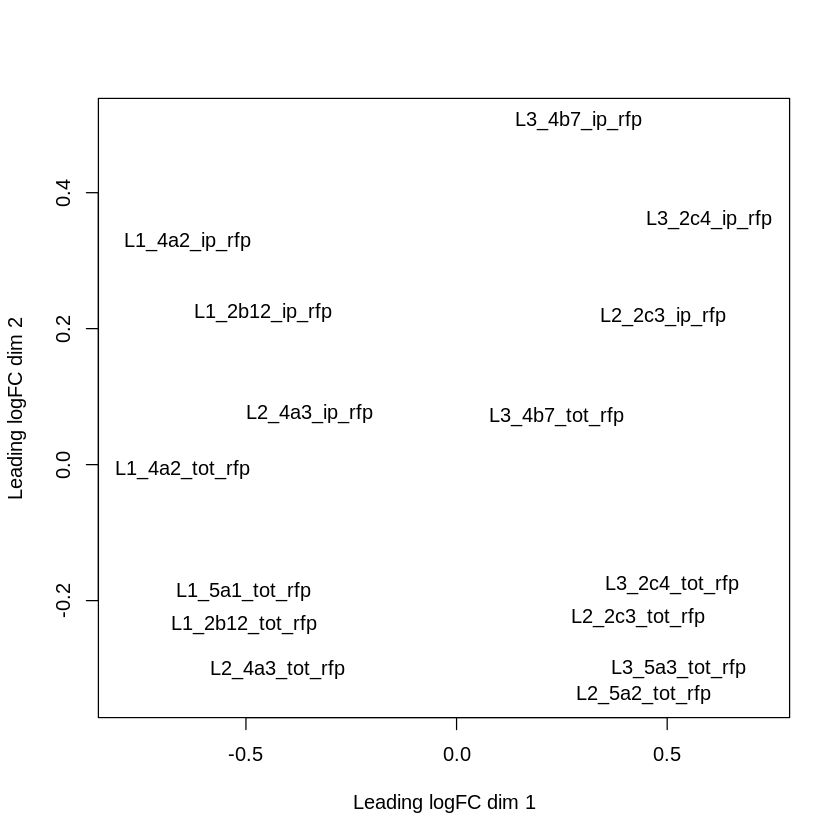

In [15]:
lcpm = cpm(data, log=TRUE)
plotMDS(lcpm, labels=rownames(data$samples))

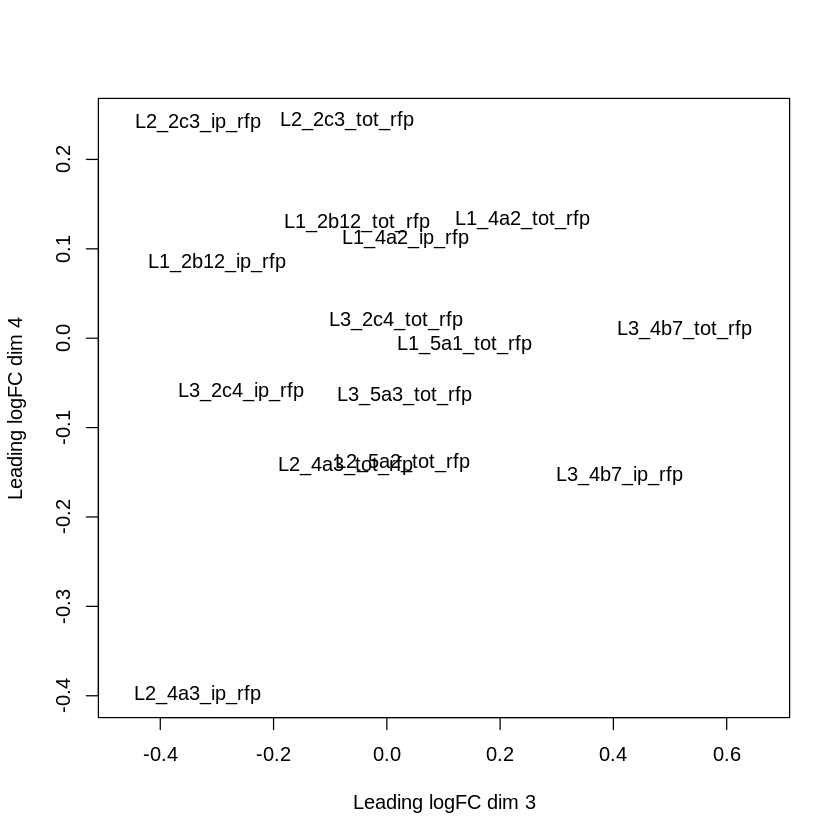

In [16]:
plotMDS(lcpm, labels=rownames(data$samples), dim=c(3,4))

In [17]:
diff_enrich = makeContrasts(line_labelS27L_FLAG_treatmentip - line_labelS27_FLAG_treatmentip, levels = colnames(design))


In [18]:
diff_enrich

,line_labelS27L_FLAG_treatmentip - line_labelS27_FLAG_treatmentip
line_labelS27_FLAG,0
line_labelS27L_FLAG,0
line_labelUnedited,0
line_labelS27_FLAG_bio_repL2,0
line_labelS27L_FLAG_bio_repL2,0
line_labelUnedited_bio_repL2,0
line_labelS27_FLAG_bio_repL3,0
line_labelS27L_FLAG_bio_repL3,0
line_labelUnedited_bio_repL3,0
line_labelS27_FLAG_treatmentip,-1


Coefficients not estimable: line_labelUnedited_treatmentip 


Warning message:
“Partial NA coefficients for 10085 probe(s)”

,group,lib.size,norm.factors,lane,clone,treatment,line,line_label,line_treatment
L1_2b12_ip_rfp,2ip,6925947,1.0438912,L1,2b12,ip,2,S27_FLAG,2ip
L1_2b12_tot_rfp,2tot,7829259,1.0214500,L1,2b12,tot,2,S27_FLAG,2tot
L1_4a2_ip_rfp,4ip,5650839,1.0178451,L1,4a2,ip,4,S27L_FLAG,4ip
L1_4a2_tot_rfp,4tot,7682414,1.0224780,L1,4a2,tot,4,S27L_FLAG,4tot
L1_5a1_tot_rfp,5tot,7145386,1.0128338,L1,5a1,tot,5,Unedited,5tot
L2_2c3_ip_rfp,2ip,5517047,0.9811225,L2,2c3,ip,2,S27_FLAG,2ip
L2_2c3_tot_rfp,2tot,7036045,0.9844647,L2,2c3,tot,2,S27_FLAG,2tot
L2_4a3_ip_rfp,4ip,4446313,0.9943063,L2,4a3,ip,4,S27L_FLAG,4ip
L2_4a3_tot_rfp,4tot,8107503,1.0172453,L2,4a3,tot,4,S27L_FLAG,4tot
L2_5a2_tot_rfp,5tot,7524899,0.9925128,L2,5a2,tot,5,Unedited,5tot


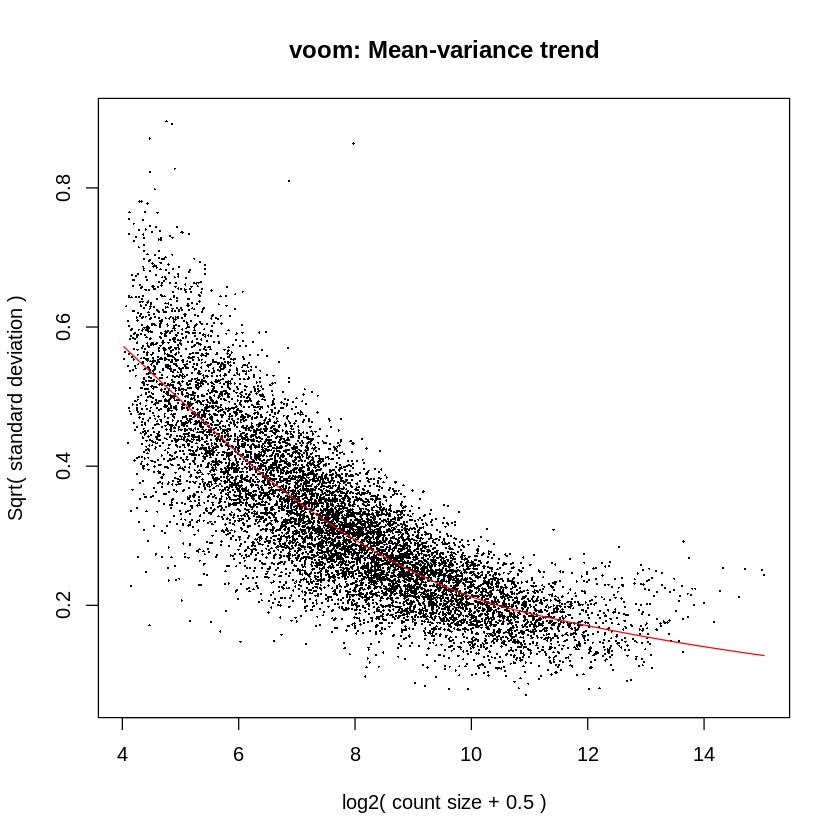

In [19]:
v <- voom(data, design, plot=TRUE)
v

Coefficients not estimable: line_labelUnedited_treatmentip 


Warning message:
“Partial NA coefficients for 10085 probe(s)”

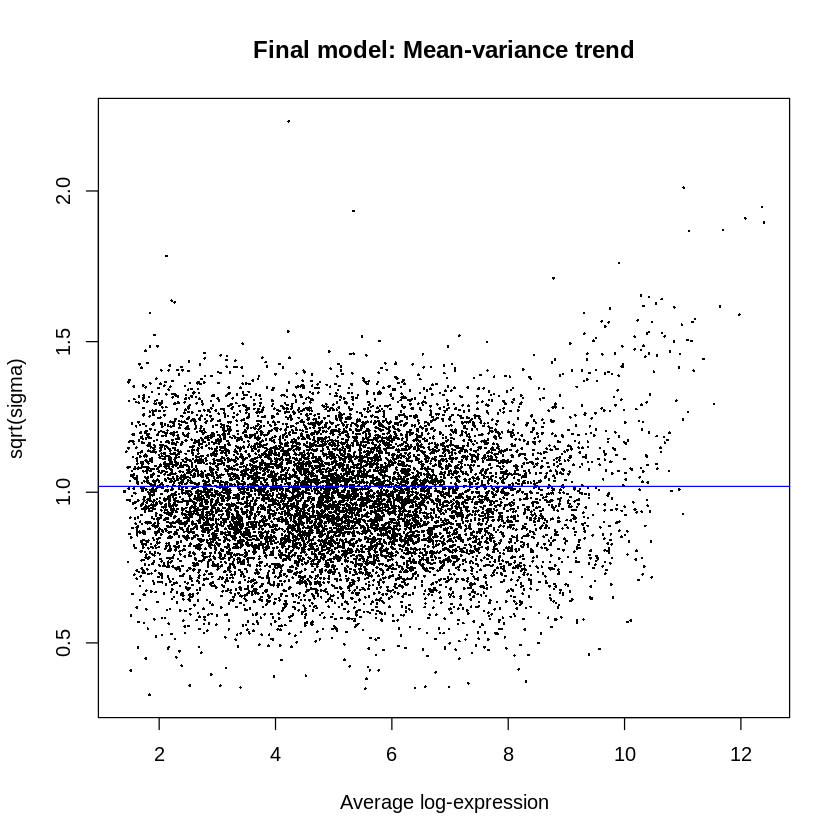

In [20]:
vfit <- lmFit(v, design)
vfit <- contrasts.fit(vfit, contrasts=diff_enrich)
efit <- eBayes(vfit)
plotSA(efit, main="Final model: Mean-variance trend")

In [21]:
dt = decideTests(efit, p.value=0.05)

In [22]:
summary(dt)

       line_labelS27L_FLAG_treatmentip - line_labelS27_FLAG_treatmentip
Down                                                                 12
NotSig                                                             9900
Up                                                                  173

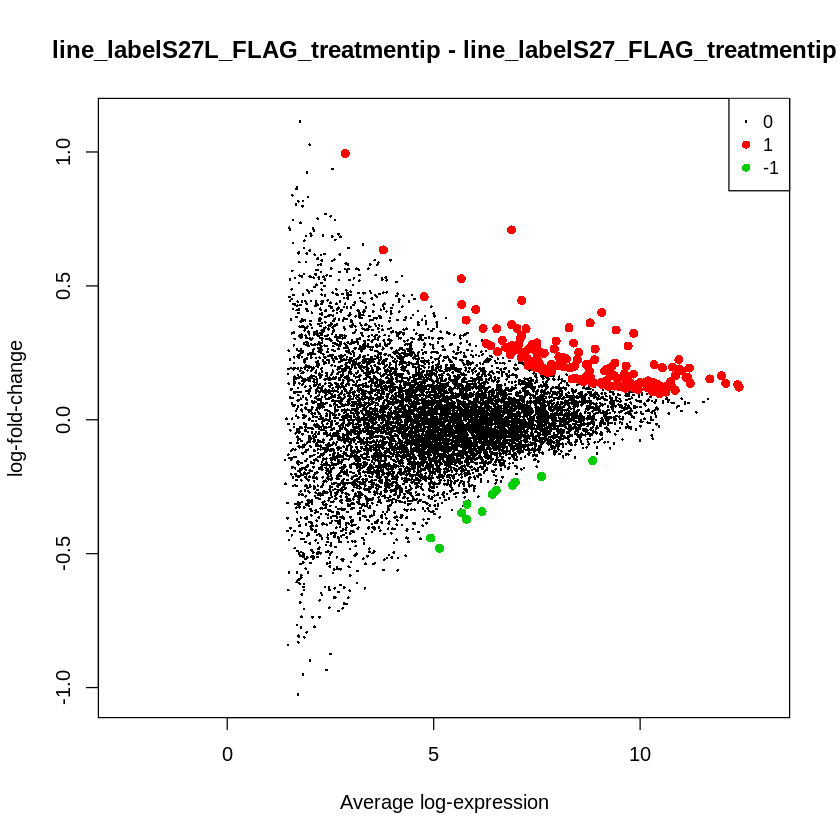

In [23]:
plotMD(efit, column=1, status=dt[,1], main=colnames(efit)[1], 
       xlim=c(-2.5,13))

In [24]:
ip_v_tot_short = topTable(efit, number=100, sort.by = 'p')
ip_v_tot_short

,logFC,AveExpr,t,P.Value,adj.P.Val,B
Tmod3_ENSMUST00000072232,0.7090083,6.887509,11.669408,3.529657e-18,3.559659e-14,28.140513
Setx_ENSMUST00000061578,0.4004832,9.072096,10.250108,1.195701e-15,6.029322e-12,24.832166
Tpr_ENSMUST00000124973,0.3228235,9.845153,9.529431,2.469339e-14,8.301096e-11,22.189499
Mdn1_ENSMUST00000178134,0.3352841,9.419308,9.319649,6.001696e-14,1.513178e-10,21.217336
Cenpf_ENSMUST00000171929,0.3618065,8.787714,8.678974,9.161900e-13,1.847955e-09,18.532707
Top2a_ENSMUST00000068031,0.2248978,10.939320,8.572402,1.443741e-12,2.426687e-09,18.336043
Dync1h1_ENSMUST00000018851,0.2757044,9.708920,8.157955,8.477586e-12,1.221378e-08,16.569981
Atad2_ENSMUST00000038194,0.3438290,8.277557,7.668667,6.845931e-11,8.630152e-08,14.348032
Atp5b_ENSMUST00000026459,0.1930106,11.190391,7.270944,3.717554e-10,4.165726e-07,12.912685
Prpf8_ENSMUST00000018449,0.2058826,10.338963,7.084524,8.189465e-10,8.259075e-07,12.189979


In [25]:
ip_v_tot = topTable(efit, number=10724, sort.by = 'p')

In [26]:
colnames(ip_v_tot)

[1] "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val" "B"

In [27]:
print(ip_v_tot[,c('logFC', 't', 'adj.P.Val', 'B')])

                                          logFC             t    adj.P.Val
Tmod3_ENSMUST00000072232           7.090083e-01  1.166941e+01 3.559659e-14
Setx_ENSMUST00000061578            4.004832e-01  1.025011e+01 6.029322e-12
Tpr_ENSMUST00000124973             3.228235e-01  9.529431e+00 8.301096e-11
Mdn1_ENSMUST00000178134            3.352841e-01  9.319649e+00 1.513178e-10
Cenpf_ENSMUST00000171929           3.618065e-01  8.678974e+00 1.847955e-09
Top2a_ENSMUST00000068031           2.248978e-01  8.572402e+00 2.426687e-09
Dync1h1_ENSMUST00000018851         2.757044e-01  8.157955e+00 1.221378e-08
Atad2_ENSMUST00000038194           3.438290e-01  7.668667e+00 8.630152e-08
Atp5b_ENSMUST00000026459           1.930106e-01  7.270944e+00 4.165726e-07
Prpf8_ENSMUST00000018449           2.058826e-01  7.084524e+00 8.259075e-07
Golgb1_ENSMUST00000039855          4.459010e-01  7.028426e+00 9.517560e-07
Eef2_ENSMUST00000047864            1.643716e-01  6.796696e+00 2.222155e-06
Nup205_ENSMUST00000043815

In [28]:
ip_v_tot$neglog10p = -log(ip_v_tot$adj.P.Val, 10)
ip_v_tot$plot_fill = rep('black', nrow(ip_v_tot))
ip_v_tot[ip_v_tot$logFC > 0.25 & ip_v_tot$adj.P.Val < 0.05,'plot_fill'] = '#D55E00'
ip_v_tot[ip_v_tot$logFC < -0.25 & ip_v_tot$adj.P.Val < 0.05,'plot_fill'] = '#56B4E9'

pal = c('black', '#D55E00', '#56B4E9')

ip_v_tot$plot_fill = factor(ip_v_tot$plot_fill, levels = pal)

blacklist = c('Tmod3_ENSMUST00000072232')
# blacklist = c(
#              'Rn7sk_ENSMUST00000083103',
#               'Gm20594_ENSMUST00000179797',
#              'D1Ertd622e_ENSMUST00000053033',
#              'Rpph1_ENSMUST00000175096',
#              'Mir291a_ENSMUST00000104815',
#              'Terc_ENSMUST00000082862',
#              'Rnu12_ENSMUST00000083242',
#              'Rnu11_ENSMUST00000104135',
#              'Mirg_ENSMUST00000183144')

In [29]:
table(ip_v_tot$plot_fill)


  black #D55E00 #56B4E9 
  10031      46       8 

In [30]:
pdf(file = file.path(project_dir, "20220303_volcano.pdf"), height = 4, width=4)

ggplot(data=ip_v_tot[!(rownames(ip_v_tot) %in% blacklist),], aes(x=logFC, y=neglog10p, color=plot_fill)) + geom_point() + scale_color_manual(values=pal) + theme_classic() + theme(legend.position='none')

dev.off()

png 
  2

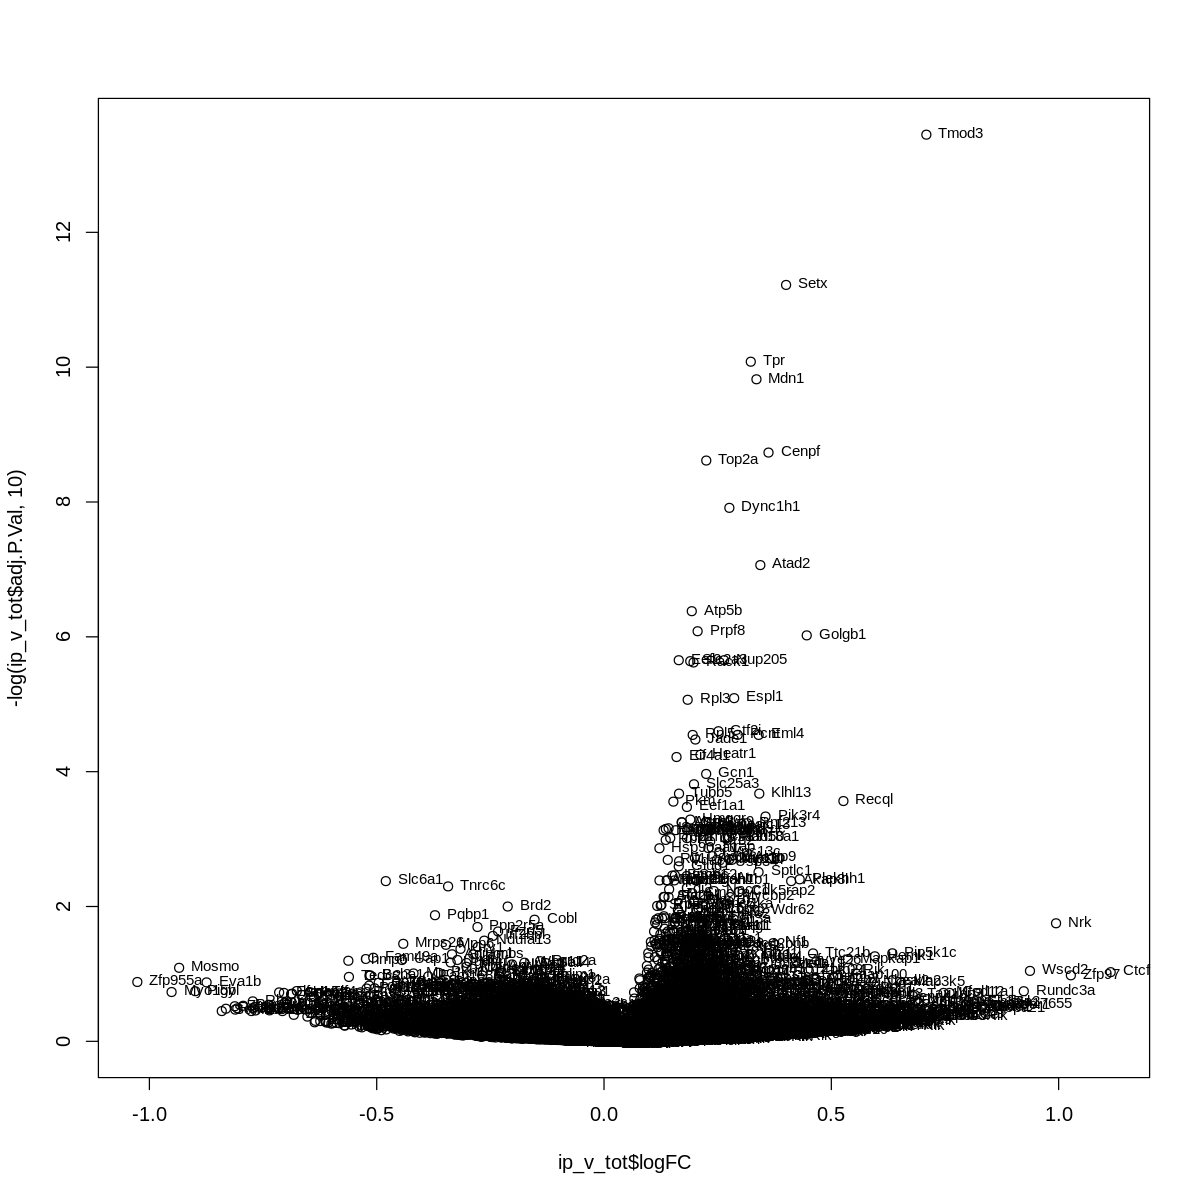

In [31]:
options(repr.plot.width=10, repr.plot.height=10)
plot(ip_v_tot$logFC, -log(ip_v_tot$adj.P.Val, 10))
text(ip_v_tot$logFC, -log(ip_v_tot$adj.P.Val, 10), labels=sub('_.*', '', rownames(ip_v_tot)), cex=0.75, pos=4)

In [32]:
write.csv(ip_v_tot, file=file.path(project_dir, "20220303_ip_v_tot.csv"), quote =FALSE)